In [1]:
import numpy as np
from numpy import random as rnd
from matplotlib import pyplot as plt
import warnings,os,datetime

import tensorflow as tf
import pandas as pd
import seaborn as sns

from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix,roc_curve,auc

from keras.models import Model,Sequential
from keras.layers import Input,Dense,LSTM,Conv2D,Conv2DTranspose,BatchNormalization,Dropout,Flatten,concatenate,Reshape

from tensorflow.examples.tutorials.mnist import input_data

warnings.filterwarnings('ignore')
sns.set()

C:\Users\Jan\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
mnist = input_data.read_data_sets('MNIST_data/',one_hot=True)

Xtrain = mnist.train.images
Xtest = mnist.test.images
ytrain = mnist.train.labels
ytest = mnist.test.labels

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
Xtrain = pp.MinMaxScaler(feature_range=(0,1)).fit_transform(Xtrain)
Xtest = pp.MinMaxScaler(feature_range=(0,1)).fit_transform(Xtest)

In [4]:
Xtrain = np.reshape(Xtrain,[-1,28,28,1])
Xtest = np.reshape(Xtest,[-1,28,28,1])

In [5]:
enc_in = Input(shape=(28,28,1,))

x = Conv2D(filters=20,kernel_size=(2,2),activation='tanh')(enc_in)
x = BatchNormalization()(x)
x = Conv2D(filters=5,kernel_size=(2,2),activation='tanh')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Flatten()(x)
x = Dense(units=100,activation='tanh')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(units=50,activation='tanh')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(units=25,activation='tanh')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
enc_out = Dense(units=10,activation='softmax')(x) 
dec_in = Dense(units=10,activation='tanh')(enc_out)
x = Dense(units=25,activation='tanh')(dec_in)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(units=50,activation='tanh')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(units=100,activation='tanh')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(units=3380,activation='tanh')(x)
x = Reshape((26,26,5))(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Conv2DTranspose(filters=20,kernel_size=(2,2),activation='relu')(x)
x = BatchNormalization()(x)
dec_out = Conv2DTranspose(filters=1,kernel_size=(2,2),activation='relu')(x)

aec = Model(enc_in,dec_out)
enc = Model(enc_in,enc_out)

dec_input = Input(shape=(10,))
xx = aec.layers[-17](dec_input)
xx = aec.layers[-16](xx)
xx = aec.layers[-15](xx)
xx = aec.layers[-14](xx)
xx = aec.layers[-13](xx)
xx = aec.layers[-12](xx)
xx = aec.layers[-11](xx)
xx = aec.layers[-10](xx)
xx = aec.layers[-9](xx)
xx = aec.layers[-8](xx)
xx = aec.layers[-7](xx)
xx = aec.layers[-6](xx)
xx = aec.layers[-5](xx)
xx = aec.layers[-4](xx)
xx = aec.layers[-3](xx)
xx = aec.layers[-2](xx)
dec_output = aec.layers[-1](xx)

dec = Model(dec_input,dec_output)

aec.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [6]:
aec.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 20)        100       
_________________________________________________________________
batch_normalization_1 (Batch (None, 27, 27, 20)        80        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 5)         405       
_________________________________________________________________
batch_normalization_2 (Batch (None, 26, 26, 5)         20        
_________________________________________________________________
dropout_1 (Dropout)          (None, 26, 26, 5)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3380)              0         
__________

In [7]:
aec.fit(Xtrain,Xtrain,epochs=1,batch_size=5)

Epoch 1/1
55000/55000 [==============================] - 1284s 23ms/step - loss: 0.0701 - acc: 0.7945


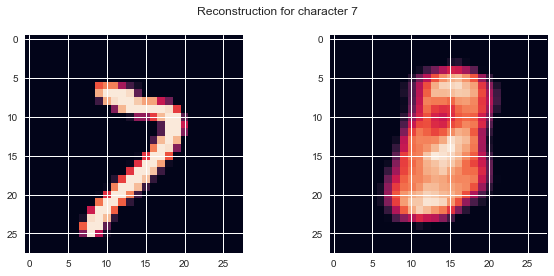

In [14]:
myid = 880

in_image = Xtest[myid,:,:,:].reshape(-1,28,28,1)
in_label = np.argmax(ytest[myid,:],axis=0)

xe = enc.predict(in_image)
xd = dec.predict(xe)

fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(10,4))
ax[0].imshow(in_image[0,:,:,0])
ax[1].imshow(xd[0,:,:,0])
fig.suptitle('Reconstruction for character %d'%(in_label))
fig.show()

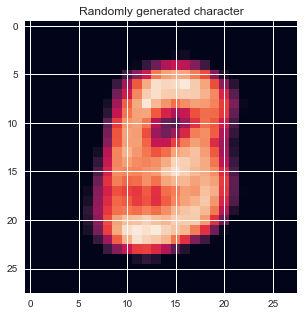

In [12]:
xc = dec.predict(0.5*rnd.random([1,10]))

fig = plt.figure(figsize=(5,5))
plt.imshow(xc[0,:,:,0])
plt.title('Randomly generated character')
fig.show()